In [1]:
import numpy as np
import pandas as pd
import os

from subprocess import check_output
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, date2num
import matplotlib.dates as mdates

import time
import copy

import chainer
import chainer.functions as F
import chainer.links as L

from mpl_finance import candlestick_ohlc
import yfinance as yf

c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
stock = 'QDVE.DE'
data = yf.download(stock, period="max")
print(data)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2015-12-03   4.767000   4.767000   4.632000   4.632000   4.632000     100
2015-12-04   4.655000   4.655000   4.655000   4.655000   4.655000       0
2015-12-07   4.723000   4.723000   4.674000   4.674000   4.674000   12615
2015-12-08   4.677000   4.677000   4.652000   4.652000   4.652000       1
2015-12-09   4.594000   4.594000   4.594000   4.594000   4.594000       0
...               ...        ...        ...        ...        ...     ...
2023-04-11  17.242001  17.264000  17.011999  17.032000  17.032000  115697
2023-04-12  17.002001  17.146000  16.870001  16.914000  16.914000   98369
2023-04-13  16.898001  16.916000  16.766001  16.902000  16.902000   90496
2023-04-14  16.993999  17.129999  16.920000  17.028000  17.028000   88997
2023-04-17  17.084000  17.198000  17.056000

In [3]:
print(data.describe())

              Open         High          Low        Close    Adj Close  \
count  1866.000000  1866.000000  1866.000000  1866.000000  1866.000000   
mean     10.263234    10.327763    10.181295    10.257925    10.257925   
std       4.592929     4.633154     4.542392     4.587817     4.587817   
min       3.783000     3.783000     3.783000     3.783000     3.783000   
25%       6.126250     6.131750     6.094250     6.108250     6.108250   
50%       8.908000     8.966000     8.778500     8.912500     8.912500   
75%      14.833500    14.928000    14.735500    14.840000    14.840000   
max      19.614000    19.740000    19.514000    19.563999    19.563999   

             Volume  
count  1.866000e+03  
mean   1.308556e+05  
std    1.605109e+05  
min    0.000000e+00  
25%    2.594450e+04  
50%    9.044700e+04  
75%    1.777670e+05  
max    1.906806e+06  


Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2961 ticks ([16638.0, ..., 19598.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

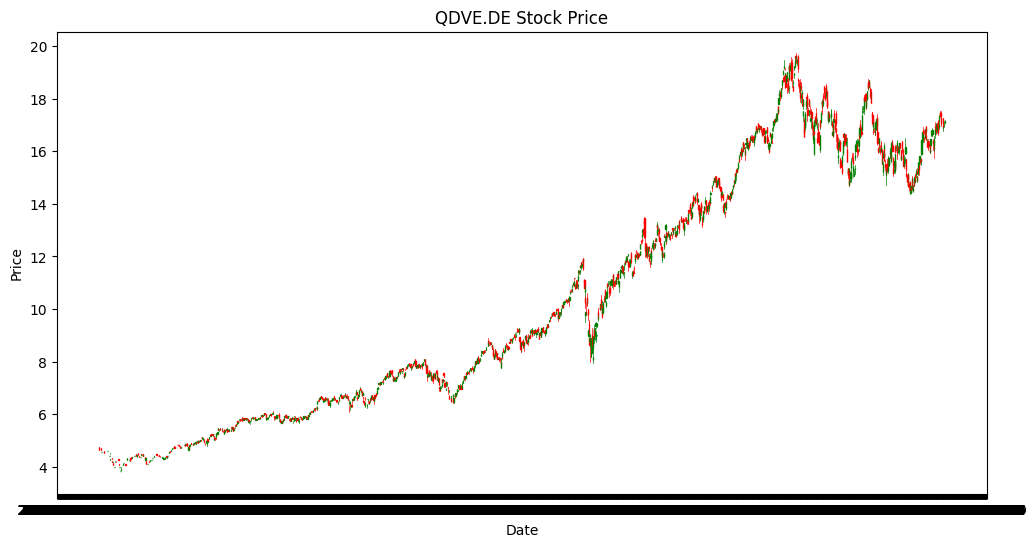

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

# convert date to mdates
data['Timestamp'] = data.index.map(mdates.date2num)

# create a list of lists containing OHLCC data
ohlc_data = []
for row in data[['Timestamp', 'Open', 'High', 'Low', 'Close']].itertuples():
    ohlc_data.append([row.Timestamp, row.Open, row.High, row.Low, row.Close])

# plot candlesticks
candlestick_ohlc(ax, ohlc_data, width=0.6, colorup='g', colordown='r')

# format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())

plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{stock} Stock Price')
plt.show()

In [5]:
date_split = '2023-01-01'
train = data[:date_split]
test = data[date_split:]
print(train.shape, test.shape)


(1792, 7) (74, 7)


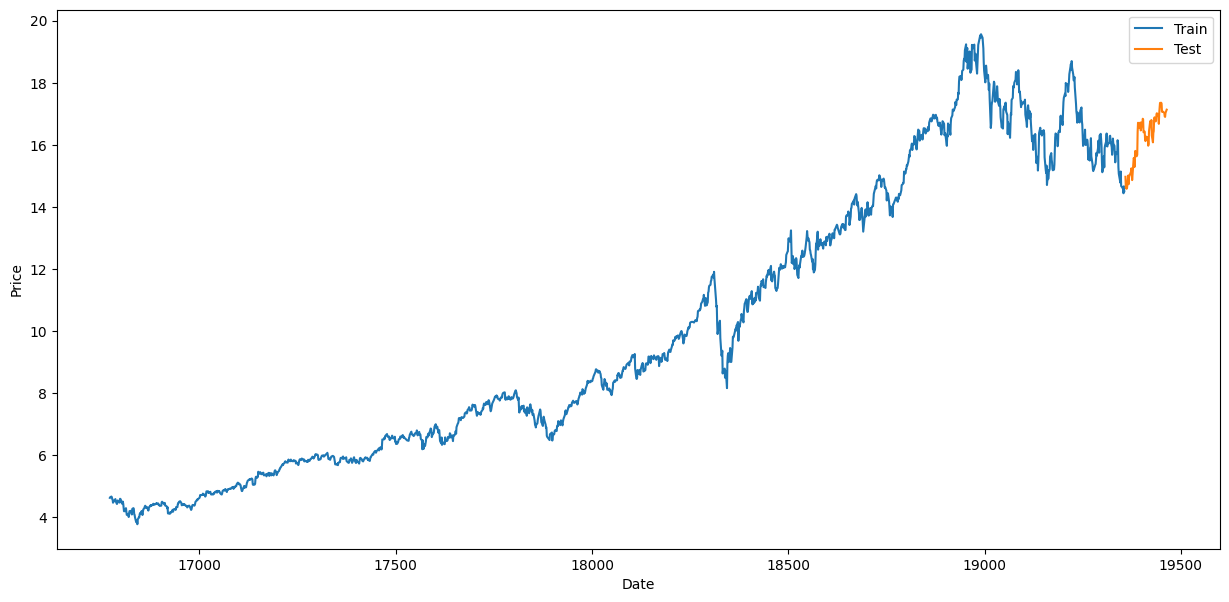

In [6]:
def plot_train_test(train, test, date_split=date_split):
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    ax.plot(date2num(train.index), train['Close'], label='Train')
    ax.plot(date2num(test.index), test['Close'], label='Test')
 
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()

    plt.show()

plot_train_test(train, test, date_split)

class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t       
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done


In [7]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.023000240325927734], 0, False)
([0.018999576568603516, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.023000240325927734, 0.018999576568603516], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [8]:
def train_dqn(env, model_file):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 30
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
      
    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        best_reward = float('-inf')       
         
        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)
                
            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.array(memory, dtype=object)
                    shuffled_memory = np.random.permutation(shuffled_memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()
                        
                        if total_reward >= best_reward:
                            print(f'Saving model with reward {total_reward} at step {total_step}')
                            best_reward = total_reward
                            chainer.serializers.save_npz(model_file, Q)                                      
                            
                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)
                


            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [9]:
model_file = 'best_model.npz'

Q, total_losses, total_rewards = train_dqn(Environment1(train), model_file)

Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -24 at step 200
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -22 at step 210
Saving model with reward -4 at step 1800
Saving model with reward -4 at step 1800
Saving model with reward -4 at step 1800
Saving model with reward -4 at step 1800
Saving model wit

In [ ]:
def plot_loss_reward(total_losses, total_rewards):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes[0].plot(total_losses, color='skyblue')
    axes[0].set_title('loss')
    axes[0].set_xlabel('epoch')
    axes[1].plot(total_rewards, color='orange')
    axes[1].set_title('reward')
    axes[1].set_xlabel('epoch')
    fig.tight_layout()
    plt.show()

In [ ]:
plot_loss_reward(total_losses, total_rewards)

In [ ]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # create candlestick data
    train_data = train_env.data[['Open', 'High', 'Low', 'Close']]
    train_data['Timestamp'] = date2num(train_env.data.index)
    
    test_data = test_env.data[['Open', 'High', 'Low', 'Close']]
    test_data['Timestamp'] = date2num(test_env.data.index)
    
    # plot
    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    ))
    
    ax.set_ylabel('Price')
    ax.set_title('Train and Test Data')
    candlestick_ohlc(ax, train_data[['Timestamp', 'Open', 'High', 'Low', 'Close']].values, width=0.6, colorup='g', colordown='r')
    candlestick_ohlc(ax, test_data[['Timestamp', 'Open', 'High', 'Low', 'Close']].values, width=0.6, colorup='b', colordown='r')
    ax.vlines(date2num(test_env.data.index[len(test_env.data)//2e99999999]), ymin=min(train_env.data.Low.min(), test_env.data.Low.min()),
              ymax=max(train_env.data.High.max(), test_env.data.High.max()), linestyles='dashed', color='black', label='Test Data')
    ax.legend()
    
    plt.show()

In [ ]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')

In [ ]:
# Double DQN

def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 30
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.array(memory, dtype=object)
                    shuffled_memory = np.random.permutation(shuffled_memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=bool)

                        q = Q(b_pobs)

                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data

                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):

                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])

                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [ ]:
Q, total_losses, total_rewards = train_ddqn(Environment1(train))

plot_loss_reward(total_losses, total_rewards)

In [ ]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'Double DQN')


In [ ]:
# Dueling Double DQN

def train_dddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()


    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 30
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.array(memory, dtype=object)
                    shuffled_memory = np.random.permutation(shuffled_memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=bool)

                        q = Q(b_pobs)

                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data

                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])

                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards


In [ ]:
Q, total_losses, total_rewards = train_dddqn(Environment1(train))


In [ ]:
plot_loss_reward(total_losses, total_rewards)


In [ ]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'Dueling Double DQN')


In [ ]:
# Train the DQN model
env = Environment1(train)
model = train_dqn(env)

In [ ]:
# Use the trained model to predict the stock price for the next 6 months
prediction = []
state = env.reset()
for i in range(6 * 30):
    predicted_price_change = env.predict()
    prediction.append(predicted_price_change)
    state, _, _ = env.step(predicted_price_change)

In [ ]:
# Convert the predicted price changes to actual stock prices
last_price = test.iloc[0]['Close']
predicted_prices = [last_price]
for p in prediction:
    last_price = last_price * (1 + p)
    predicted_prices.append(last_price)

In [ ]:
 Print the predicted stock prices for the next 6 months
print(predicted_prices[-180:])
